In [1]:
import pandas as pd

In [2]:
ratings_path="/content/drive/MyDrive/Dataset/ml-100k/u.data"
movies_path="/content/drive/MyDrive/Dataset/ml-100k/u.item"
users_path="/content/drive/MyDrive/Dataset/ml-100k/u.user"
genre_path="/content/drive/MyDrive/Dataset/ml-100k/u.genre"


In [3]:
ratings = pd.read_csv(ratings_path, sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv(movies_path, sep='|', header=None, encoding='latin-1', names=['item_id', 'title'] + [str(i) for i in range(22)])

In [4]:
print(ratings.head())
print(movies.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
   item_id              title            0   1  \
0        1   Toy Story (1995)  01-Jan-1995 NaN   
1        2   GoldenEye (1995)  01-Jan-1995 NaN   
2        3  Four Rooms (1995)  01-Jan-1995 NaN   
3        4  Get Shorty (1995)  01-Jan-1995 NaN   
4        5     Copycat (1995)  01-Jan-1995 NaN   

                                                   2  3  4  5  6  7  ...  12  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...  0  0  0  1  1  ...   0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...  0  1  1  0  0  ...   0   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...  0  0  0  0  0  ...   0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...  0  1  0  0  0  ...   0   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)  0  0  0  0 

In [5]:
data = pd.merge(ratings, movies[['item_id', 'title']], on='item_id')

In [6]:
data.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
user_sequences = data.groupby('user_id')['title'].apply(list)

In [8]:
movie_to_index = {title: idx for idx, title in enumerate(movies['title'])}
index_to_movie = {idx: title for title, idx in movie_to_index.items()}

In [9]:
user_sequences = user_sequences.apply(lambda seq: [movie_to_index[title] for title in seq])

In [10]:
print(user_sequences.head())

user_id
1    [241, 50, 264, 85, 256, 221, 39, 28, 143, 117,...
2    [241, 301, 256, 273, 0, 276, 499, 99, 287, 236...
3    [301, 345, 326, 331, 321, 180, 287, 337, 293, ...
4    [326, 287, 293, 327, 263, 257, 359, 10, 356, 3...
5    [376, 450, 256, 221, 39, 28, 386, 391, 143, 0,...
Name: title, dtype: object


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [12]:
max_seq_length = max(user_sequences.apply(len))
X = pad_sequences(user_sequences, maxlen=max_seq_length, padding='post')

In [13]:
y = np.zeros_like(X)
for i, seq in enumerate(X):
    y[i, :-1] = seq[1:]
    y[i, -1] = seq[0]

In [14]:
y = np.expand_dims(y, axis=-1)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train: (754, 737)
Shape of y_train: (754, 737, 1)
Shape of X_val: (189, 737)
Shape of y_val: (189, 737, 1)


In [17]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(754, 737) (189, 737) (754, 737, 1) (189, 737, 1)


In [18]:
import numpy as np

# Clip indices to be within the valid range
max_index = len(movie_to_index) - 1
X_train = np.clip(X_train, 0, max_index)
y_train = np.clip(y_train, 0, max_index)
X_val = np.clip(X_val, 0, max_index)
y_val = np.clip(y_val, 0, max_index)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed

# Define the model architecture
model = Sequential([
    Embedding(input_dim=1682, output_dim=50, input_length=max_seq_length),
    LSTM(100, return_sequences=True),
    TimeDistributed(Dense(len(movie_to_index), activation='softmax'))
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.build(input_shape=(None, max_seq_length))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 737, 50)             │          84,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 737, 100)            │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 737, 1664)           │         168,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,564 (1.19 MB)

 Trainable params: 312,564 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
y = y.reshape(y.shape[0], y.shape[1])

In [21]:
print(f"Max index in X_train: {X_train.max()}")
print(f"Max index in y_train: {y_train.max()}")
print(f"Movie to index length: {len(movie_to_index)}")

Max index in X_train: 1663
Max index in y_train: 1663
Movie to index length: 1664


In [22]:
# Check shapes of inputs and targets
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

# Check if any sequence length is zero
for i, seq in enumerate(user_sequences):
    if len(seq) == 0:
        print(f"Empty sequence found at index {i}")

# Check if the model summary is consistent with data
model.summary()


Shape of X: (943, 737)
Shape of y: (943, 737)
Shape of X_train: (754, 737)
Shape of y_train: (754, 737, 1)
Shape of X_val: (189, 737)
Shape of y_val: (189, 737, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 737, 50)             │          84,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 737, 100)            │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 737, 1664)           │         168,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,564 (1.19 MB)

 Trainable params: 312,564 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
 history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 227s 7s/step - accuracy: 0.7250 - loss: 6.1932 - val_accuracy: 0.8593 - val_loss: 2.1651
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - accuracy: 0.8527 - loss: 1.6810 - val_accuracy: 0.8593 - val_loss: 1.0789
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - accuracy: 0.8544 - loss: 1.0925 - val_accuracy: 0.8593 - val_loss: 1.0178
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.8610 - loss: 0.9982 - val_accuracy: 0.8593 - val_loss: 0.9954
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.8546 - loss: 1.0219 - val_accuracy: 0.8592 - val_loss: 0.9755
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 191s 6s/step - accuracy: 0.8560 - loss: 0.9881 - val_accuracy: 0.8591 - val_loss: 0.9583
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.8582 - loss: 0.9560 - val_accuracy: 0.8587 - val_loss: 0.9374
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.8604 - loss: 0.9156 - val_accuracy: 0.8587 - v

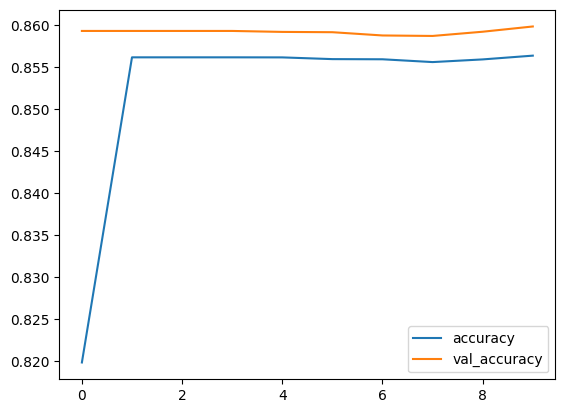

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

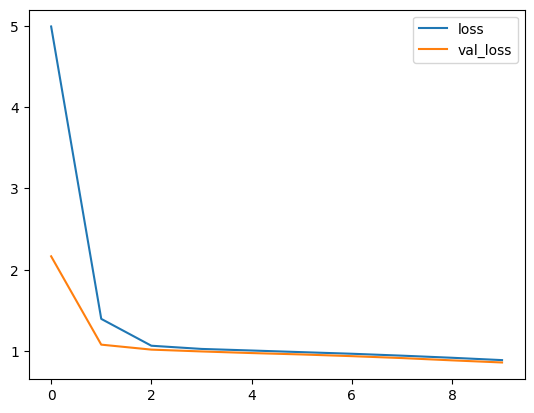

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [30]:
user_id = 1
user_ratings = data[data['user_id'] == user_id]

In [31]:
user_ratings.head()

,user_id,item_id,rating,timestamp,title
14,1,242,5,889751633,Kolya (1996)
433,1,51,4,878543275,Legends of the Fall (1994)
832,1,265,4,878542441,"Hunt for Red October, The (1990)"
1336,1,86,5,878543541,"Remains of the Day, The (1993)"
1573,1,257,4,874965954,Men in Black (1997)


In [25]:
def get_recommendations(user_id, model, top_n=10):
    # Get the user's sequence of movie ratings
    user_sequence = user_sequences[user_id]

    # Pad the sequence
    user_sequence = pad_sequences([user_sequence], maxlen=max_seq_length, padding='post')

    # Predict the next movie
    preds = model.predict(user_sequence)

    # Get the top N movie indices
    top_n_indices = np.argsort(preds[0, -1, :])[-top_n:][::-1]

    # Convert indices to movie titles
    top_n_movies = [index_to_movie[idx] for idx in top_n_indices]

    return top_n_movies

# Get recommendations for a user
user_id = 1
recommendations = get_recommendations(user_id, model)
print(f"Top recommendations for user {user_id}: {recommendations}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Top recommendations for user 1: ['Toy Story (1995)', 'L.A. Confidential (1997)', 'Star Trek: First Contact (1996)', 'Men in Black (1997)', 'Broken Arrow (1996)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', 'Kolya (1996)', 'Hunt for Red October, The (1990)', 'Aladdin (1992)', 'Silence of the Lambs, The (1991)']
